 # Data Preprocessing
 This notebook implements the data preprocessing steps.

 Prerequisites:
 - Run the `notebook 1_data_exploration_and_download.ipynb` to get the data

 The notebook is structured as follows:
 1. Load raw data (downloaded from the notebook 1_data_exploration_and_download.ipynb)
 2. Select the features to be used for the modeling
 3. Preprocess the data to create time features, nighttime mask, clear sky GHI baseline and normalize the data
 4. Save the normalized data and the scalers for later steps

 For this project, we will split train/val/test data based on the year of the data.
 - Train: 2011-2018
 - Val: 2019
 - Test: 2020

 The output data will be saved in the `data/processed/` directory:
 - `train_normalized_<timestamp>.h5`: Normalized training data
 - `val_normalized_<timestamp>.h5`: Normalized validation data
 - `test_normalized_<timestamp>.h5`: Normalized test data
 - `scalers_<timestamp>.pkl`: Scalers used for normalization

## 1. Setup and Data Loading

Define data loading parameters

In [1]:
# Import required libraries
import numpy as np
import h5py
import datetime
from pathlib import Path

# Find all data files
train_files = [
    "data/raw/himawari7_2011_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2012_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2013_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2014_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2015_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2016_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2017_Hồ-Chí-Minh.h5",
    "data/raw/himawari7_2018_Hồ-Chí-Minh.h5",
]
val_files = [
    "data/raw/himawari7_2019_Hồ-Chí-Minh.h5",
]
test_files = [
    "data/raw/himawari7_2020_Hồ-Chí-Minh.h5",
]

print(f"Found {len(train_files)} training files: {[Path(f).name for f in train_files]}")
print(f"Found {len(val_files)} validation files: {[Path(f).name for f in val_files]}")
print(f"Found {len(test_files)} test files: {[Path(f).name for f in test_files]}")

# Check if the files exist
if not (train_files and val_files and test_files):
    print("Warning: Some data files are missing!")

# List of features to use
AVAILABLE_FEATURES = [
    'ghi',                     # Target variable
    'air_temperature',         # Weather features
    'wind_speed',
    'relative_humidity',
    'dew_point',
    'surface_pressure',
    'total_precipitable_water',
    'cloud_type',              # Cloud features
    'cloud_fill_flag',
    'cld_opd_dcomp',
    'cld_press_acha',
    'cld_reff_dcomp',
    'clearsky_ghi',            # Clear sky estimates
    'clearsky_dni',
    'clearsky_dhi',
    'solar_zenith_angle',      # Solar geometry
    'surface_albedo',          # Surface properties
    'ozone',                   # Atmospheric properties
    'aod',
    'ssa',
    'asymmetry',
    'alpha'
]

# Choose features which could be potentially useful for the modeling
# This is to reduce the number of features to be processed
# by excluding the features which are unrelevant to the target variable
# In the later modelling part, we will continue to select only subset of those features to input into the model
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',
    'cld_opd_dcomp',
    'cld_press_acha',
    'cld_reff_dcomp',
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo',
    'aod'
]

# Target variable
TARGET_VARIABLE = 'ghi'


Found 8 training files: ['himawari7_2011_Hồ-Chí-Minh.h5', 'himawari7_2012_Hồ-Chí-Minh.h5', 'himawari7_2013_Hồ-Chí-Minh.h5', 'himawari7_2014_Hồ-Chí-Minh.h5', 'himawari7_2015_Hồ-Chí-Minh.h5', 'himawari7_2016_Hồ-Chí-Minh.h5', 'himawari7_2017_Hồ-Chí-Minh.h5', 'himawari7_2018_Hồ-Chí-Minh.h5']
Found 1 validation files: ['himawari7_2019_Hồ-Chí-Minh.h5']
Found 1 test files: ['himawari7_2020_Hồ-Chí-Minh.h5']


### 1.1 Exploring the Data Structure

Let's examine the structure of our H5 files.

In [2]:
def explore_h5_structure(h5_path):
    try:
        with h5py.File(h5_path, 'r') as f:
            print(f"\nExploring {h5_path}")
            print("\nDatasets:")
            for key in f.keys():
                dataset = f[key]
                print(f"  /{key} {dataset.shape}: {dataset.dtype}")
                if key == 'meta':
                    # Explore metadata structure
                    print("  Metadata fields:")
                    for field in dataset.dtype.names:
                        values = dataset[field]
                        unique_count = len(np.unique(values))
                        sample = np.unique(values)[:5]
                        print(f"    {field}: {unique_count} unique values, examples: {sample}")
                elif len(dataset) > 0 and dataset.ndim > 0:
                    # For numerical data, show some statistics
                    try:
                        if dataset.dtype in [np.float32, np.float64, np.int16, np.int32, np.uint8, np.uint16]:
                            # Take a small sample to calculate stats
                            sample = dataset[:10, :100] if dataset.ndim > 1 else dataset[:10]
                            stats = {
                                'min': np.min(sample),
                                'max': np.max(sample),
                                'mean': np.mean(sample),
                                'has_nan': np.isnan(sample).any()
                            }
                            print(f"    Sample stats: {stats}")
                    except Exception as e:
                        print(f"    Error computing stats: {e}")
    except Exception as e:
        print(f"Error exploring {h5_path}: {e}")

# Explore first file from each set
if train_files:
    explore_h5_structure(train_files[0])
if val_files:
    explore_h5_structure(val_files[0])
if test_files:
    explore_h5_structure(test_files[0])



Exploring data/raw/himawari7_2011_Hồ-Chí-Minh.h5

Datasets:
  /air_temperature (17520, 105): int16
    Sample stats: {'min': 222, 'max': 289, 'mean': 262.133, 'has_nan': False}
  /alpha (17520, 105): uint8
    Sample stats: {'min': 108, 'max': 153, 'mean': 134.02, 'has_nan': False}
  /aod (17520, 105): uint16
    Sample stats: {'min': 2236, 'max': 4310, 'mean': 2966.096, 'has_nan': False}
  /asymmetry (17520, 105): int8
  /cld_opd_dcomp (17520, 105): uint16
    Sample stats: {'min': 0, 'max': 8000, 'mean': 130.394, 'has_nan': False}
  /cld_press_acha (17520, 105): uint16
    Sample stats: {'min': 0, 'max': 916, 'mean': 85.85, 'has_nan': False}
  /cld_reff_dcomp (17520, 105): uint16
    Sample stats: {'min': 0, 'max': 1890, 'mean': 120.721, 'has_nan': False}
  /clearsky_dhi (17520, 105): uint16
    Sample stats: {'min': 63, 'max': 248, 'mean': 162.847, 'has_nan': False}
  /clearsky_dni (17520, 105): uint16
    Sample stats: {'min': 263, 'max': 769, 'mean': 600.489, 'has_nan': False}
  

### 1.2 Raw Data Loading
Load the raw data with selected features.

In [3]:
from utils.data_loading_utils import load_dataset

# Load data with selected features
print("Loading training data...")
train_data = load_dataset(train_files, n_sites=None, features=SELECTED_FEATURES, target_variable="ghi", apply_scaling=True, time_interval="1h")
print("\nLoading validation data...")
val_data = load_dataset(val_files, n_sites=None, features=SELECTED_FEATURES, target_variable="ghi", apply_scaling=True, time_interval="1h")
print("\nLoading test data...")
test_data = load_dataset(test_files, n_sites=None, features=SELECTED_FEATURES, target_variable="ghi", apply_scaling=True, time_interval="1h")


Loading training data...
Loading from himawari7_2011_Hồ-Chí-Minh.h5...
  Using all available sites in the file
  Selected 105 sites
  Scaled solar_zenith_angle: range changed from [80.00, 17861.00] to [0.80, 178.61]
  Scaled clearsky_ghi: range changed from [0.00, 1033.00] to [0.00, 1033.00]
  Scaled ghi: range changed from [0.00, 1029.00] to [0.00, 1029.00]
Loading from himawari7_2012_Hồ-Chí-Minh.h5...
  Using all available sites in the file
  Selected 105 sites
  Scaled solar_zenith_angle: range changed from [81.00, 17861.00] to [0.81, 178.61]
  Scaled clearsky_ghi: range changed from [0.00, 1048.00] to [0.00, 1048.00]
  Scaled ghi: range changed from [0.00, 1040.00] to [0.00, 1040.00]
Loading from himawari7_2013_Hồ-Chí-Minh.h5...
  Using all available sites in the file
  Selected 105 sites
  Scaled solar_zenith_angle: range changed from [81.00, 17861.00] to [0.81, 178.61]
  Scaled clearsky_ghi: range changed from [0.00, 1030.00] to [0.00, 1030.00]
  Scaled ghi: range changed from [0

### 1.3 Visualize the Data
Plot the data for a location to check the data quality.

Location: Latitude 11.0100, Longitude 106.4200, Elevation 12m, Timezone UTC+7
Showing timesteps 0 to 47 out of 70128 total timesteps


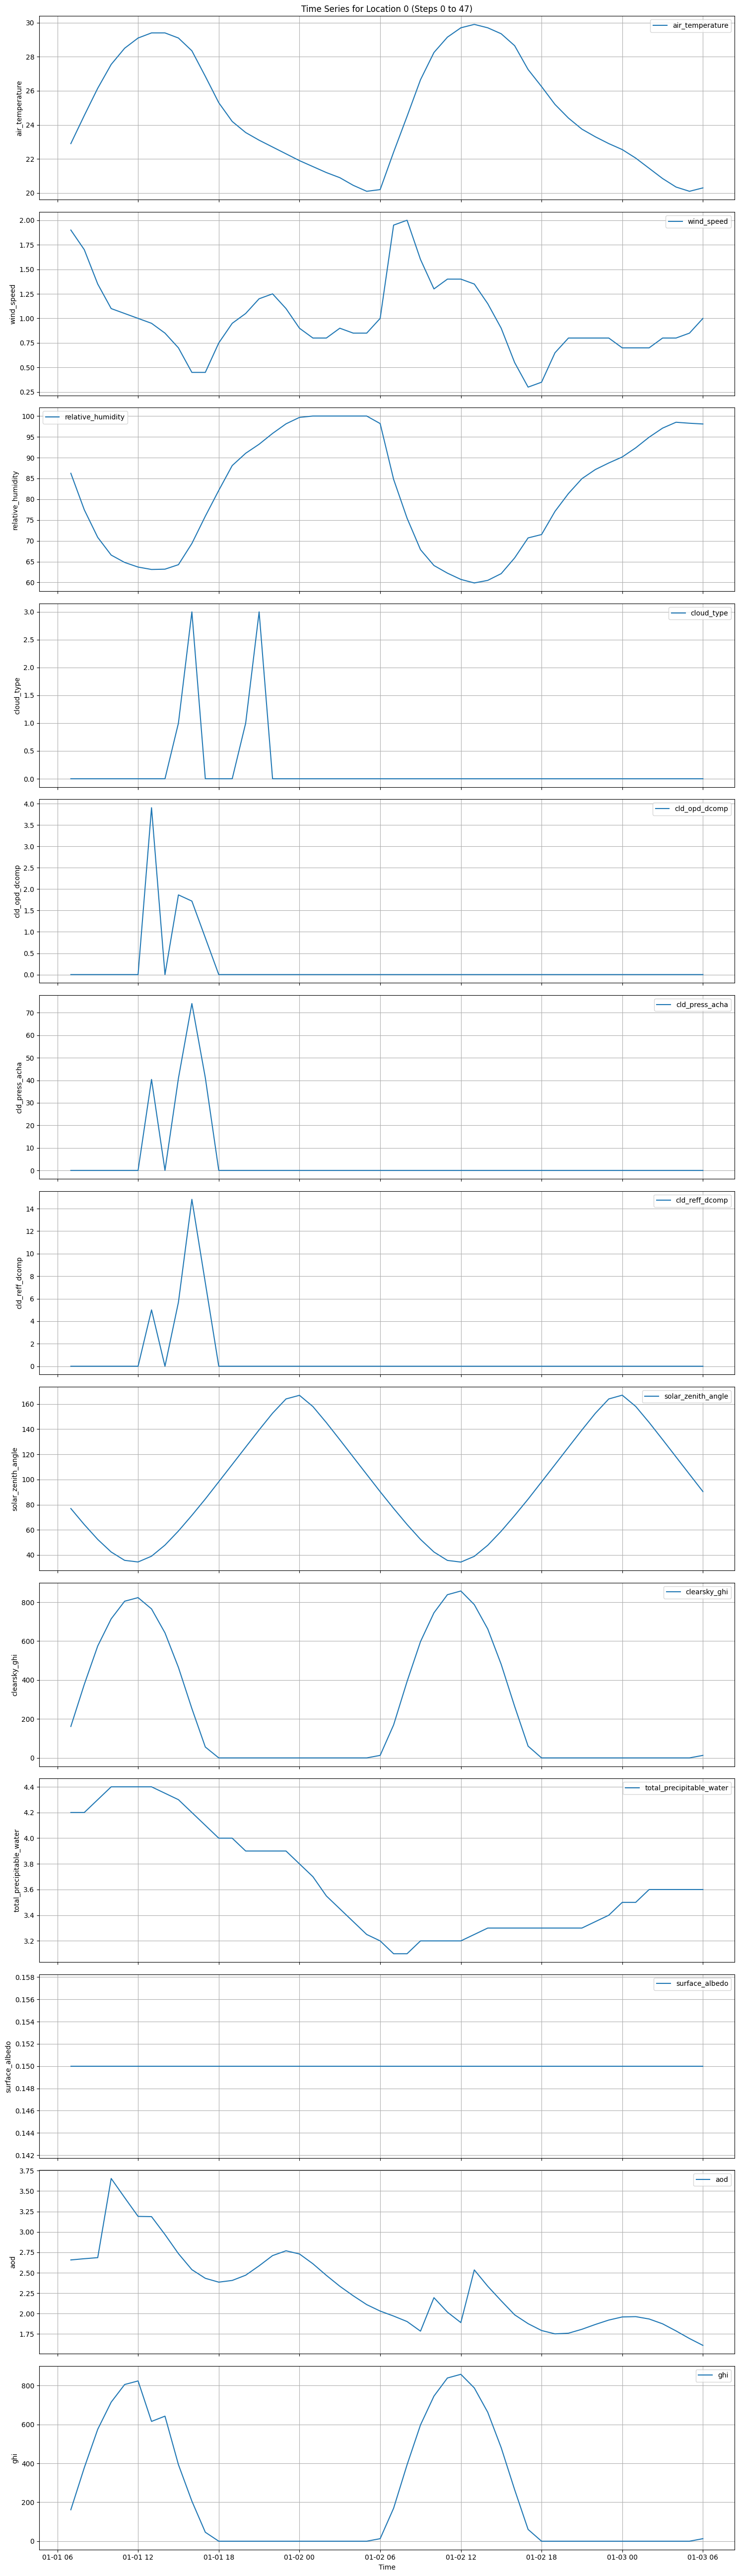

In [4]:
from utils.plot_utils import plot_time_series

# Plot data for a few locations
fig = plot_time_series(train_data,
                       features=SELECTED_FEATURES + ['nighttime_mask', "ghi"],
                       location_idx=0,
                       start_idx=0,
                       n_steps=48)


## 2. Data Preprocessing

Preprocess the data to create time features and normalize the data.

### 2.1 Time Feature Engineering
Convert the timestamps to frequency-based time features.

The output time features are:
- `hour_sin`: Sine of the hour of the day
- `hour_cos`: Cosine of the hour of the day
- `day_sin`: Sine of the day of the year
- `day_cos`: Cosine of the day of the year
- `month_sin`: Sine of the month of the year
- `month_cos`: Cosine of the month of the year
- `dow_sin`: Sine of the day of the week
- `dow_cos`: Cosine of the day of the week

In [5]:
from utils.normalize_utils import create_time_features

# Create time features
train_time_features_dict = create_time_features(train_data['timestamps'])
val_time_features_dict = create_time_features(val_data['timestamps'])
test_time_features_dict = create_time_features(test_data['timestamps'])

# Add each time feature to the respective data dictionaries
print("Time features:")
for key, value in train_time_features_dict.items():
    train_data[key] = value
    val_data[key] = val_time_features_dict[key]
    test_data[key] = test_time_features_dict[key]
    print(f"  - {key}: {value.shape}")


Time features:
  - hour_sin: (70128,)
  - hour_cos: (70128,)
  - day_sin: (70128,)
  - day_cos: (70128,)
  - month_sin: (70128,)
  - month_cos: (70128,)
  - dow_sin: (70128,)
  - dow_cos: (70128,)


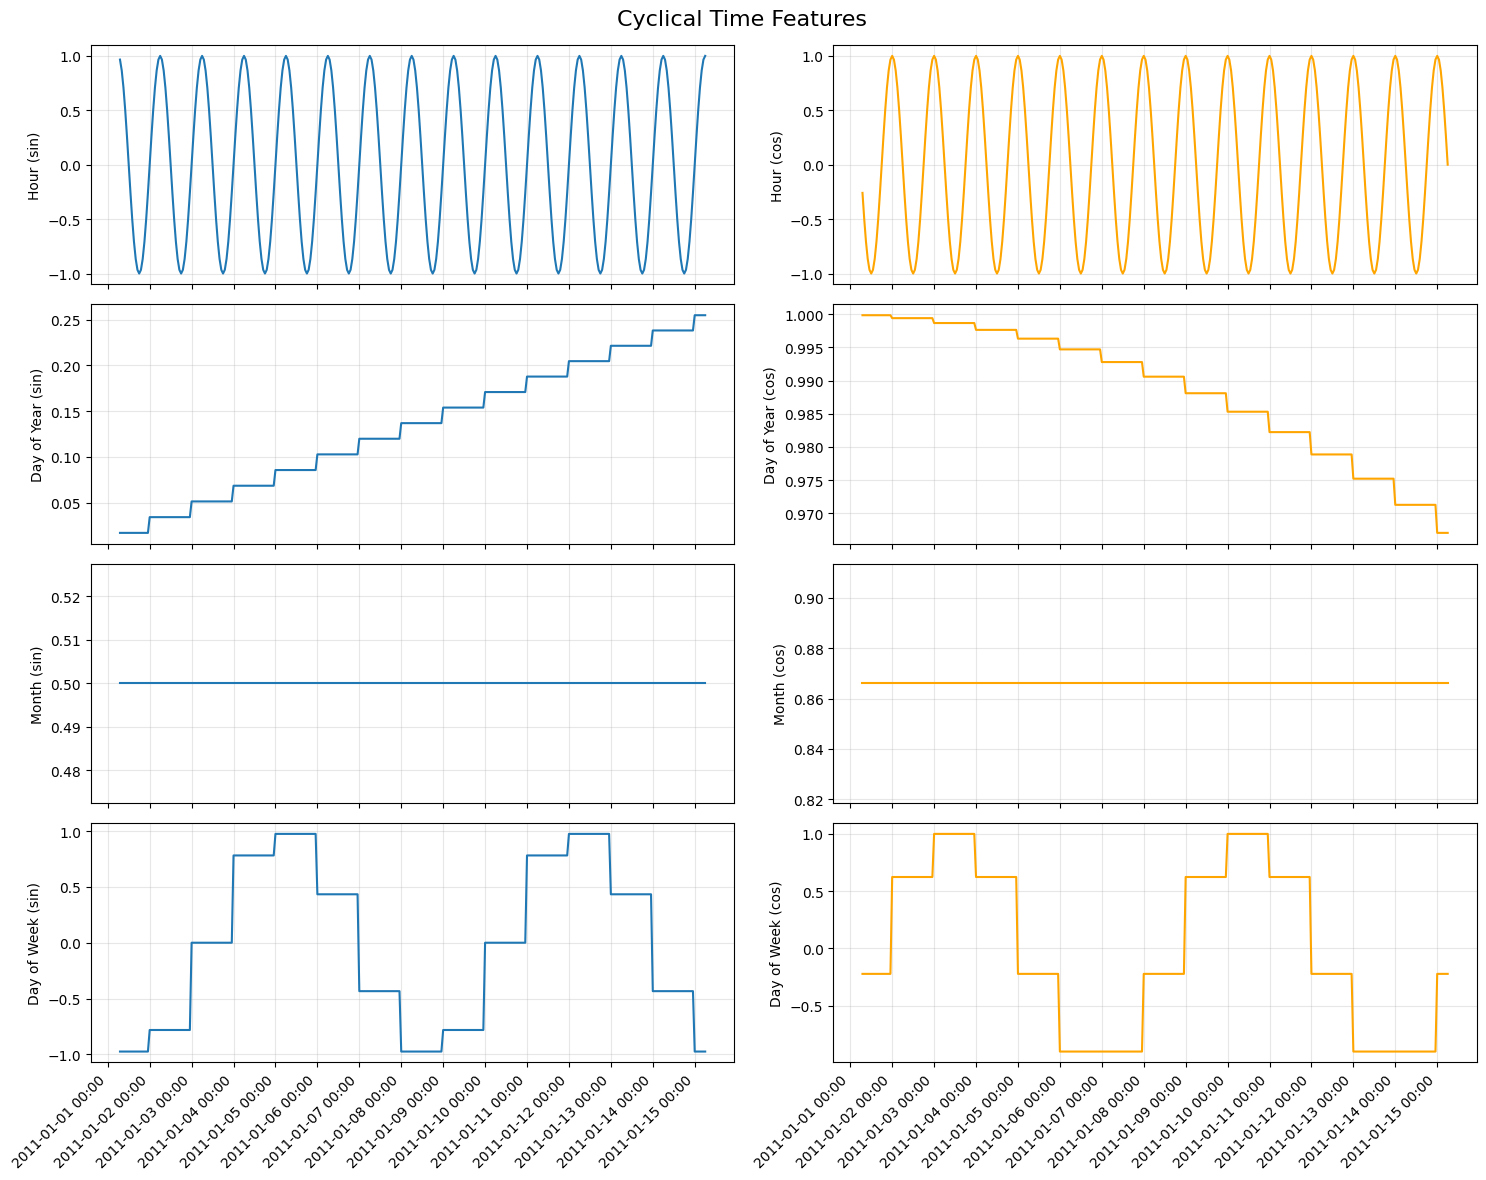

In [6]:
# Plot the time features for a few days to check
from utils.plot_utils import plot_time_features

_ = plot_time_features(train_data['timestamps'], train_time_features_dict, n_days=14)


### 2.2 Create nighttime mask feature

Create a nighttime mask to indicate the nighttime hours.
The nighttime mask is computed using the solar zenith angle.

The output nighttime mask is:
- `nighttime_mask`: 1 for nighttime, 0 for daytime

In [7]:
from utils.features_utils import compute_nighttime_mask

# Compute nighttime mask using solar zenith angle if available
train_nighttime_mask = compute_nighttime_mask(
    train_data['timestamps'], train_data['latitude'], train_data['longitude'], train_data.get('solar_zenith_angle')
)
train_data['nighttime_mask'] = train_nighttime_mask
# Do the same for validation
val_nighttime_mask = compute_nighttime_mask(
    val_data['timestamps'], val_data['latitude'], val_data['longitude'], val_data.get('solar_zenith_angle')
)
val_data['nighttime_mask'] = val_nighttime_mask
# Do the same for test data
test_nighttime_mask = compute_nighttime_mask(
    test_data['timestamps'], test_data['latitude'], test_data['longitude'], test_data.get('solar_zenith_angle')
)
test_data['nighttime_mask'] = test_nighttime_mask
print(f"  Computed nighttime_mask with {np.sum(train_nighttime_mask)} night hours out of {train_nighttime_mask.size} total hours")

# Add nighttime mask to selected features if not already present
if "nighttime_mask" not in SELECTED_FEATURES:
    SELECTED_FEATURES += ["nighttime_mask"]


Using solar zenith angle data (format: degrees)
Degrees range 4.46-176.32°
Using solar zenith angle data (format: degrees)
Degrees range 4.46-176.32°
Using solar zenith angle data (format: degrees)
Degrees range 4.46-176.32°
  Computed nighttime_mask with 3695679 night hours out of 7363440 total hours


Raw Solar Zenith Angle range: 34.39 to 167.005 (dtype: float64)
Display may be incorrect. SZA should be in degrees with ~0-180 range.
Location: Latitude 11.0100, Longitude 106.4200, Elevation 12m, Timezone UTC+7
Time period: 2011-01-01 07:00:00 to 2011-01-03 06:00:00
Day hours: 22 (45.8%), Night hours: 26 (54.2%)


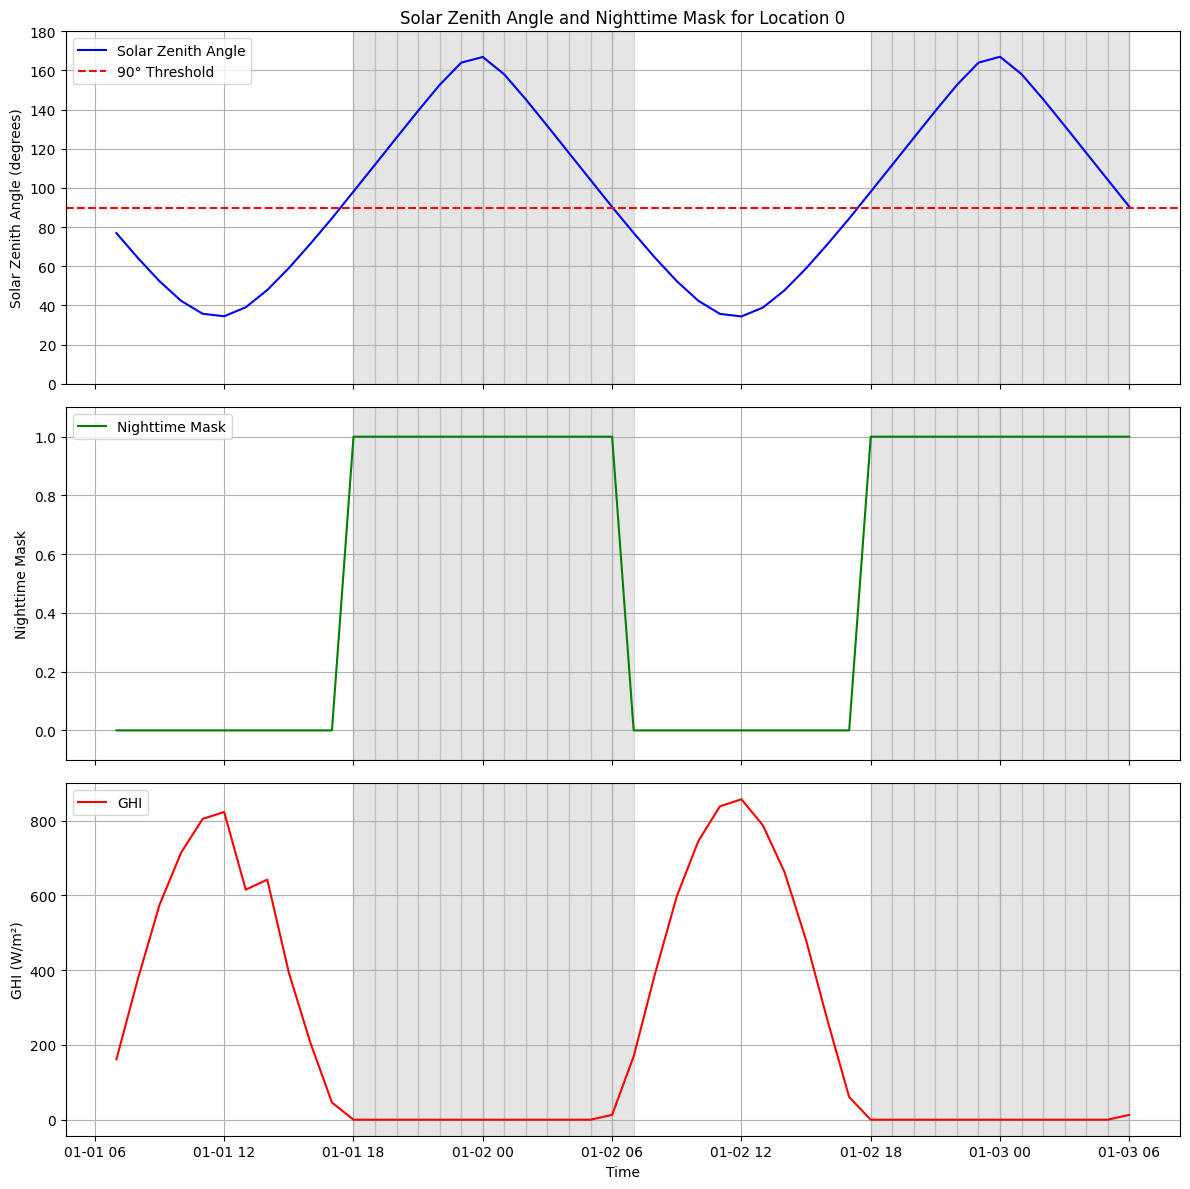

In [8]:
from utils.plot_utils import plot_solar_day_night

_ = plot_solar_day_night(train_data, location_idx=0, n_steps=48, start_idx=0)


### 2.3 Create Clear Sky GHI baseline (if not provided)

Create a clear sky GHI baseline based on the solar zenith angle if `clearsky_ghi` is not provided, e.g. for old data from vietnam2016.h5 or old satellite data.

The output clear sky GHI is:
- `clearsky_ghi`: Clear sky GHI

In [9]:
from utils.features_utils import compute_clearsky_ghi

# Use pre-computed clear sky GHI if available, otherwise compute it
if 'clearsky_ghi' not in train_data:
    clear_sky_ghi = compute_clearsky_ghi(
        train_data['timestamps'], train_data['latitude'], train_data['longitude'], train_data.get('solar_zenith_angle')
    )
    train_data['clearsky_ghi'] = clear_sky_ghi

if 'clearsky_ghi' not in val_data:
    clear_sky_ghi = compute_clearsky_ghi(
        val_data['timestamps'], val_data['latitude'], val_data['longitude'], val_data.get('solar_zenith_angle')
    )
    val_data['clearsky_ghi'] = clear_sky_ghi

if 'clearsky_ghi' not in test_data:
    clear_sky_ghi = compute_clearsky_ghi(
        test_data['timestamps'], test_data['latitude'], test_data['longitude'], test_data.get('solar_zenith_angle')
    )
    test_data['clearsky_ghi'] = clear_sky_ghi

if "clearsky_ghi" not in SELECTED_FEATURES:
    SELECTED_FEATURES += ["clearsky_ghi"]


Location: Latitude 11.0100, Longitude 106.4200, Elevation 12m, Timezone UTC+7
Showing timesteps 0 to 71 out of 70128 total timesteps


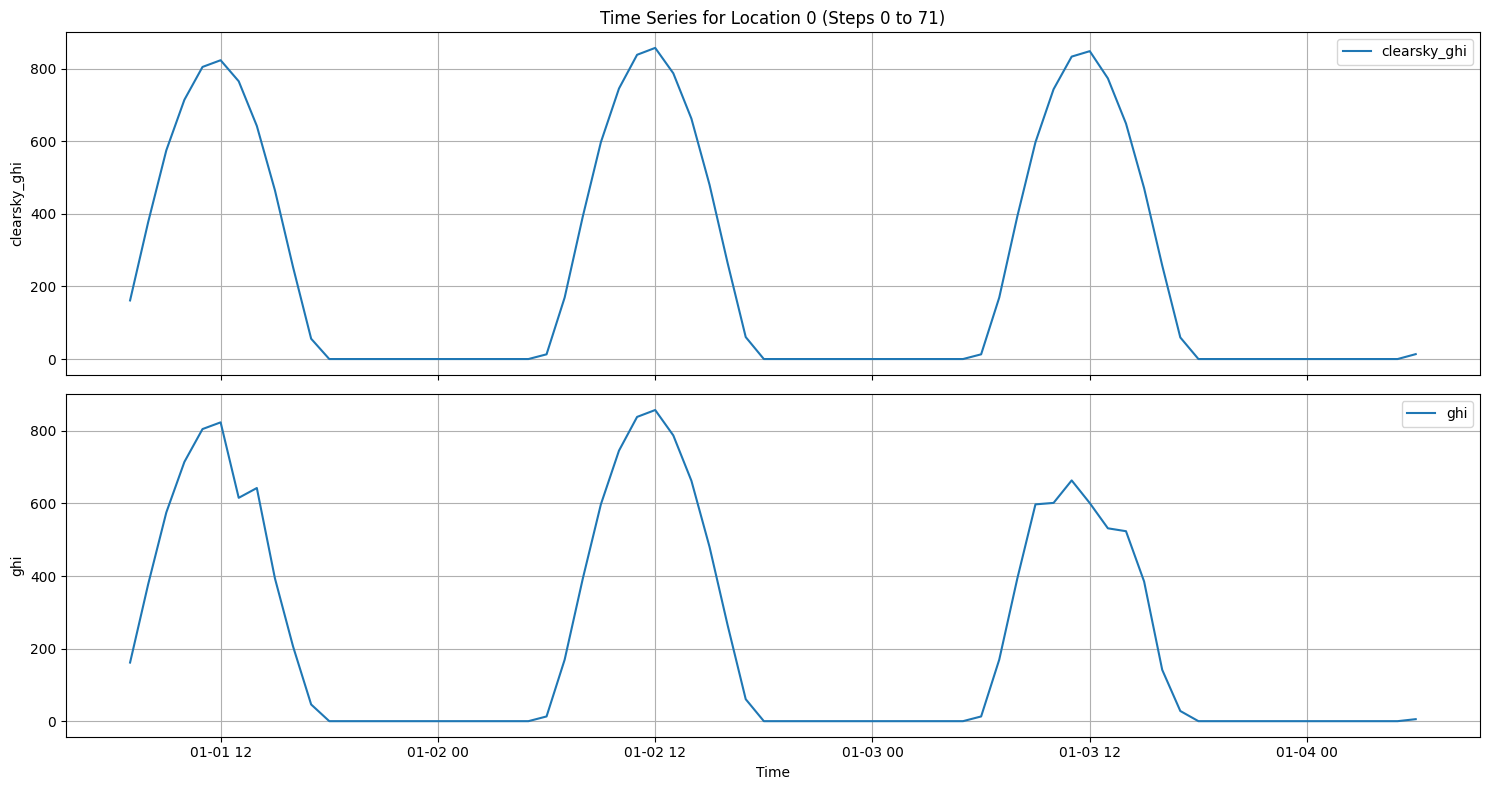

In [10]:
# Plot the clear sky GHI and the actual GHI for a few days to check
from utils.plot_utils import plot_time_series

# Plot data for a few locations
fig = plot_time_series(train_data,
                       features=["clearsky_ghi", "ghi"],
                       location_idx=0,
                       start_idx=0,
                       n_steps=72)


### 2.4 Data Normalization

Normalize the data to have zero mean and unit variance.

The output normalized data is:
- `normalized_data`: Normalized data
- `scalers`: Scalers used for normalization

In [11]:
from utils.normalize_utils import normalize_data

# Normalize data
norm_train_data, scalers = normalize_data(train_data, SELECTED_FEATURES, TARGET_VARIABLE, scalers=None, fit_scalers=True)
norm_val_data, _ = normalize_data(val_data, SELECTED_FEATURES, TARGET_VARIABLE, scalers=scalers, fit_scalers=False)
norm_test_data, _ = normalize_data(test_data, SELECTED_FEATURES, TARGET_VARIABLE, scalers=scalers, fit_scalers=False)

# Print normalized data shapes
print("Normalized data shapes:")
for key in norm_train_data:
    if isinstance(norm_train_data[key], np.ndarray):
        print(f"  {key}: {norm_train_data[key].shape}")


Normalized data shapes:
  time_index: (140256,)
  time_index_local: (70128,)
  hour_sin: (70128,)
  hour_cos: (70128,)
  day_sin: (70128,)
  day_cos: (70128,)
  month_sin: (70128,)
  month_cos: (70128,)
  dow_sin: (70128,)
  dow_cos: (70128,)
  latitude: (105,)
  longitude: (105,)
  elevation: (105,)
  nighttime_mask: (70128, 105)
  air_temperature: (70128, 105)
  wind_speed: (70128, 105)
  relative_humidity: (70128, 105)
  cloud_type: (70128, 105)
  cld_opd_dcomp: (70128, 105)
  cld_press_acha: (70128, 105)
  cld_reff_dcomp: (70128, 105)
  solar_zenith_angle: (70128, 105)
  clearsky_ghi: (70128, 105)
  total_precipitable_water: (70128, 105)
  surface_albedo: (70128, 105)
  aod: (70128, 105)
  ghi: (70128, 105)


### 2.5 Save the Normalized Data

Save the normalized data and the scalers for later steps.

In [12]:
from utils.data_persistence import save_normalized_data, save_scalers

# Create metadata
train_metadata = {
    "selected_features": SELECTED_FEATURES,
    "target_variable": TARGET_VARIABLE,
    "selected_feature_org_shape": train_data[SELECTED_FEATURES[0]].shape,
    "target_org_shape": train_data[TARGET_VARIABLE].shape,
    "raw_files": train_files,
}
val_metadata = {
    "selected_features": SELECTED_FEATURES,
    "target_variable": TARGET_VARIABLE,
    "selected_feature_org_shape": val_data[SELECTED_FEATURES[0]].shape,
    "target_org_shape": val_data[TARGET_VARIABLE].shape,
    "raw_files": val_files,
}
test_metadata = {
    "selected_features": SELECTED_FEATURES,
    "target_variable": TARGET_VARIABLE,
    "selected_feature_org_shape": test_data[SELECTED_FEATURES[0]].shape,
    "target_org_shape": test_data[TARGET_VARIABLE].shape,
    "raw_files": test_files,
}

# Save normalized data
save_normalized_data(norm_train_data, output_dir="data/processed", prefix="train", add_timestamp=True)
save_normalized_data(norm_val_data, output_dir="data/processed", prefix="val", add_timestamp=True)
save_normalized_data(norm_test_data, output_dir="data/processed", prefix="test", add_timestamp=True)

# Save scalers
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_scalers(scalers, filepath=f"data/processed/scalers_{timestamp}.pkl")



Saved normalized data to data/processed/train_normalized_20250508_034608.h5
Saved normalized data to data/processed/val_normalized_20250508_034634.h5
Saved normalized data to data/processed/test_normalized_20250508_034639.h5
Saved 16 scalers to data/processed/scalers_20250508_034644.pkl


True